In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
import os

# Check what's inside the dataset folder
print(os.listdir("/kaggle/input/walmart-sales-forecast"))


['features.csv', 'stores.csv', 'train.csv', 'test.csv']


13:21:48 - cmdstanpy - INFO - Chain [1] start processing
13:21:48 - cmdstanpy - INFO - Chain [1] done processing


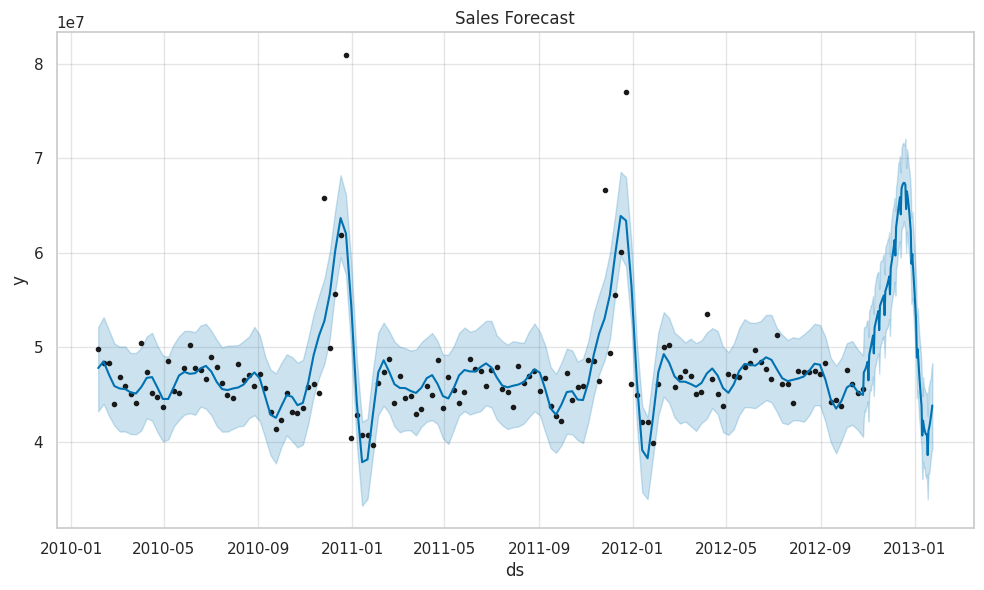

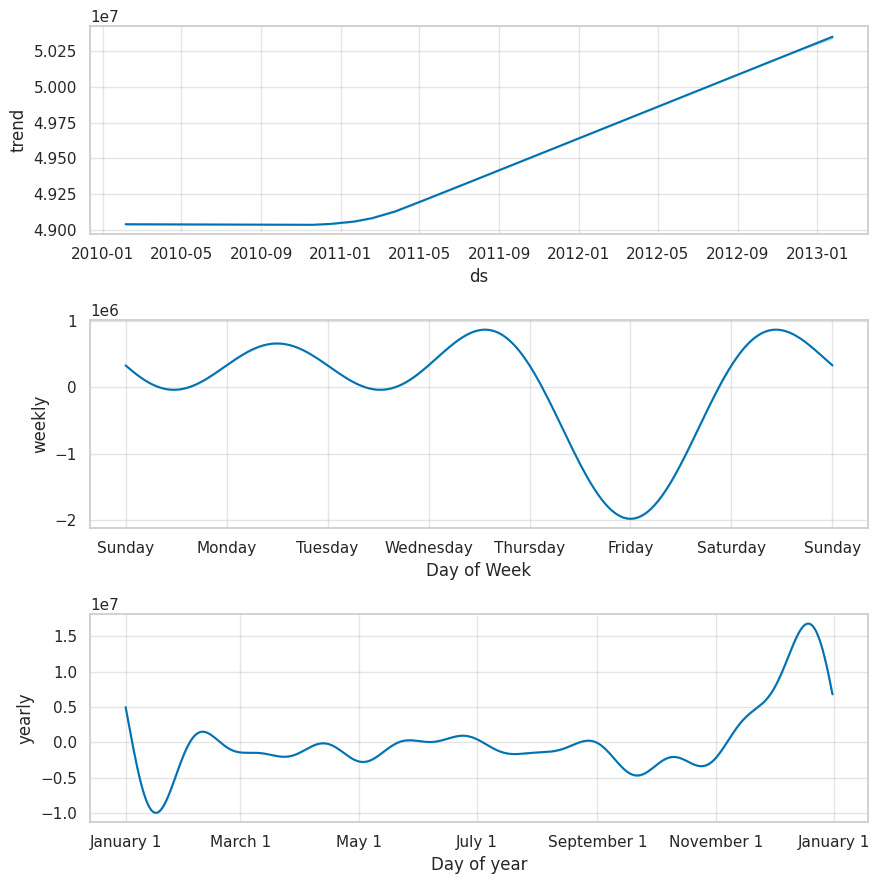

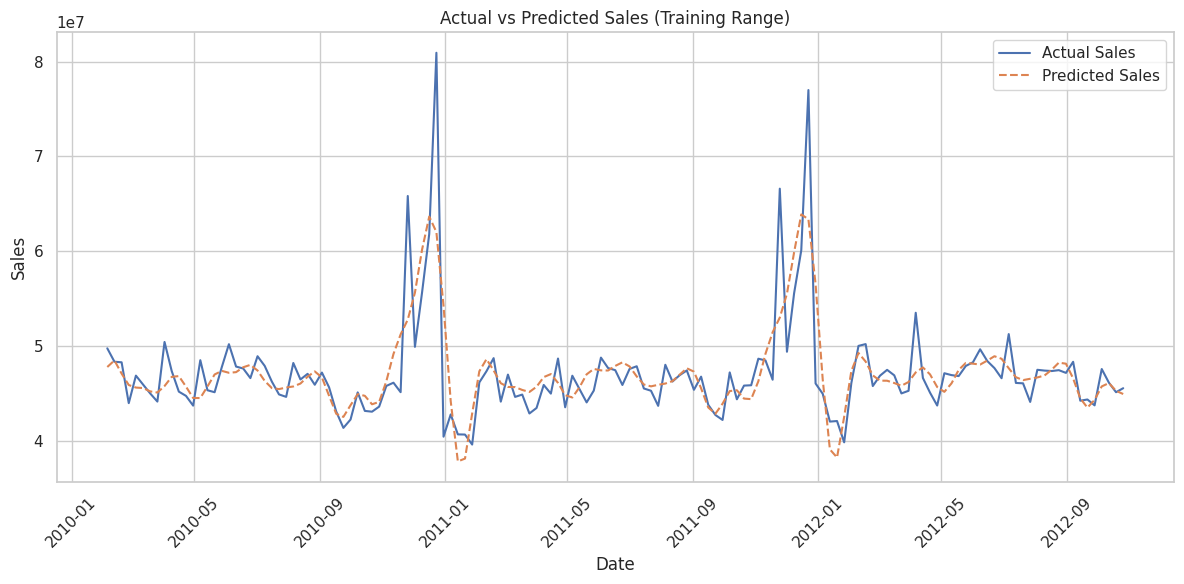

In [3]:
# Install Prophet
!pip install -q prophet

# Imports
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Load all necessary CSV files
train = pd.read_csv("/kaggle/input/walmart-sales-forecast/train.csv")
features = pd.read_csv("/kaggle/input/walmart-sales-forecast/features.csv")
stores = pd.read_csv("/kaggle/input/walmart-sales-forecast/stores.csv")

# Merge all into a single DataFrame
df = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
df = df.merge(stores, on="Store", how="left")

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Aggregate sales by Date (total across all stores/depts)
daily_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Rename columns for Prophet
daily_sales = daily_sales.rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# OPTIONAL: Log scale (Prophet can benefit from stabilized variance)
# daily_sales['y'] = np.log1p(daily_sales['y'])

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(daily_sales)

# Forecast next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Sales Forecast")

# Plot forecast components
fig2 = model.plot_components(forecast)

# Plot actual vs predicted (only in training range)
merged = daily_sales.merge(forecast[['ds', 'yhat']], on='ds')
plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['y'], label='Actual Sales')
plt.plot(merged['ds'], merged['yhat'], label='Predicted Sales', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (Training Range)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
